---

---

# **Emotion Recognition from Speech using Mel Spectrograms and CNNs**

You can find all the details of the methods used in this notebook in the `REPORT.md` file on my [GitHub repository](https://github.com/SigurdST/emotion_recognition).

---

---

# 1 - ***Data preparation***

### Import the data
We use `librosa`, a package specialized in audio analysis.

In [828]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [887]:
import torch

device = torch.device("mps")  # Définit le GPU MPS comme appareil

In [829]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/d07 (3).wav,44100,3.032562


In [830]:
df_metadata.shape

(605, 4)

---

## 1.A - **Data exploration**

### Waveform of the first file

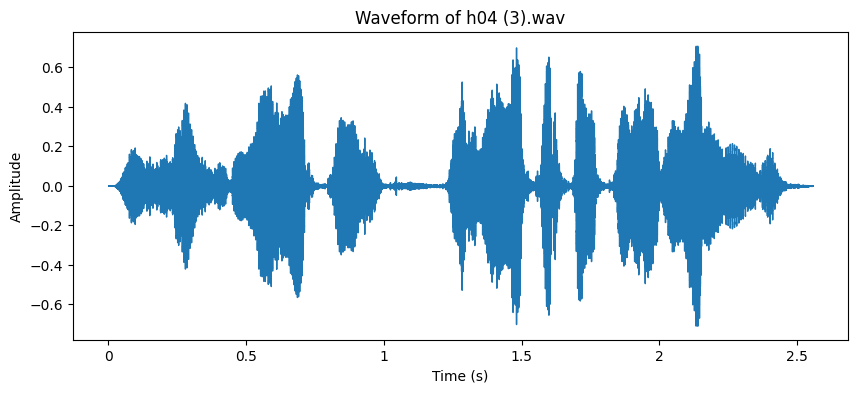

In [831]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Adding an *emotion* column

In [832]:
# Extract emotion labels from file names (the first letter of the file name indicates emotion)
df_metadata['emotion'] = df_metadata['file_name'].str[0]

# Map single-letter codes to emotion names
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

### Example of waveform for every emotion

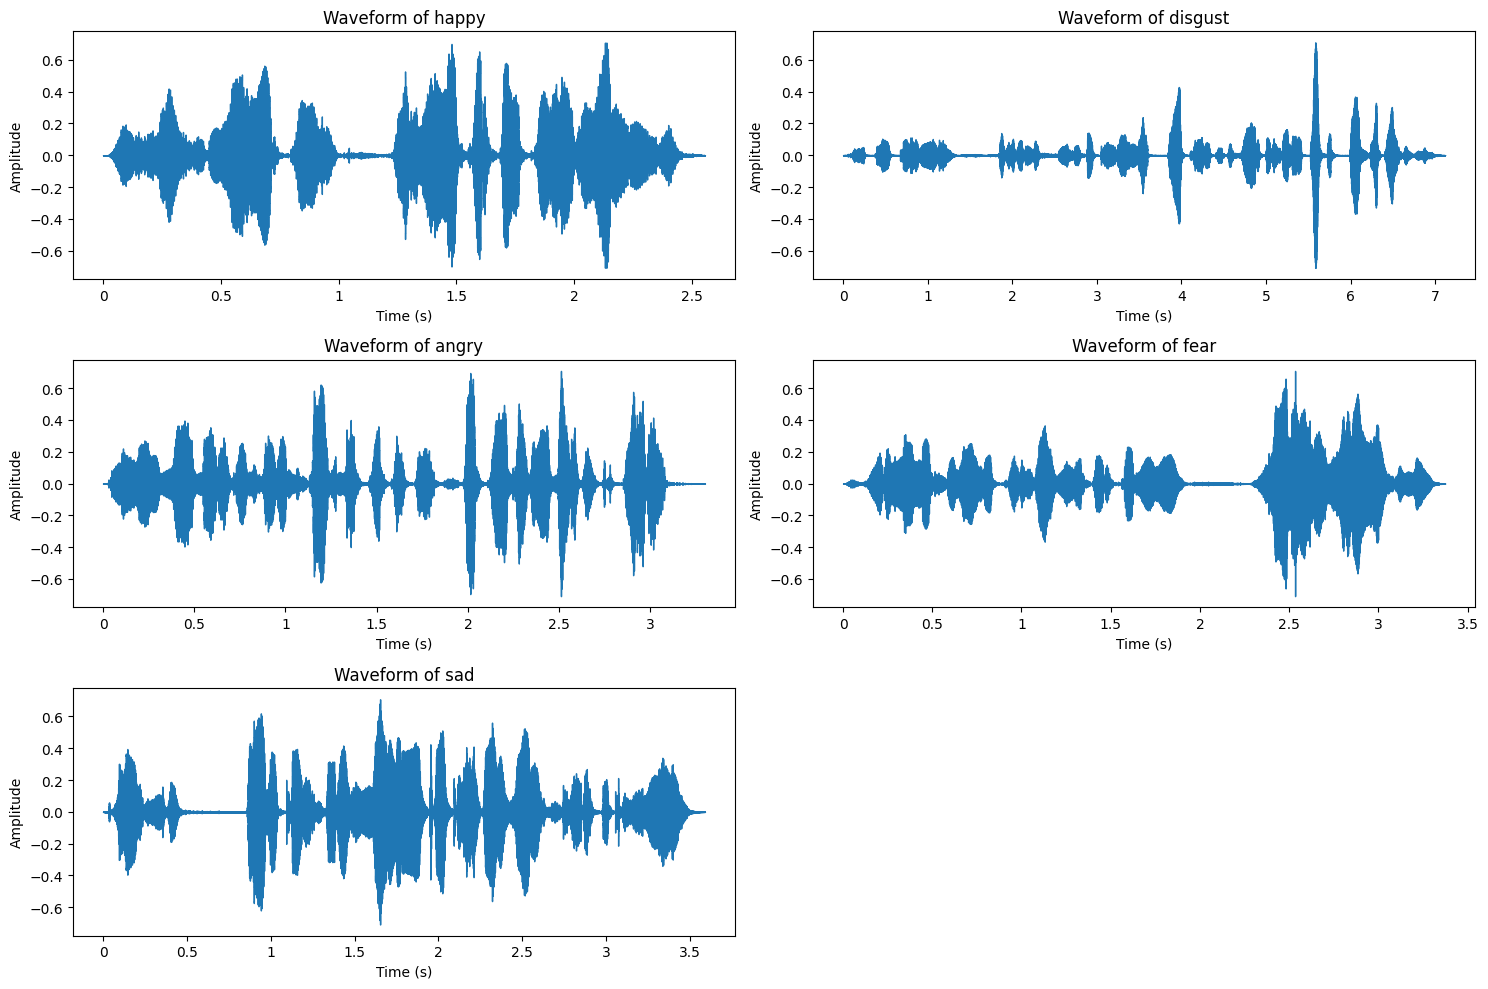

In [833]:
# Obtaining the unique emotions
emotions = df_metadata['emotion'].unique()
files_per_emotion = {}

# Select one file per emotion
for emotion in emotions:
    files_per_emotion[emotion] = df_metadata[df_metadata['emotion'] == emotion].iloc[0]['file_path']

# Create a figure to plot the waveforms
plt.figure(figsize=(15, 10))

for i, (emotion, file_path) in enumerate(files_per_emotion.items(), 1):
    y, sr = librosa.load(file_path, sr=None)
    plt.subplot(3, 2, i) 
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Histogram of audio durations

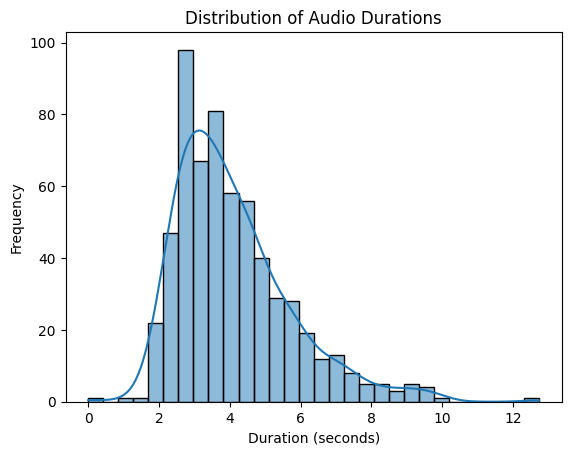

In [834]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

We observe that there is an audio with a duration of 0 second, we remove it

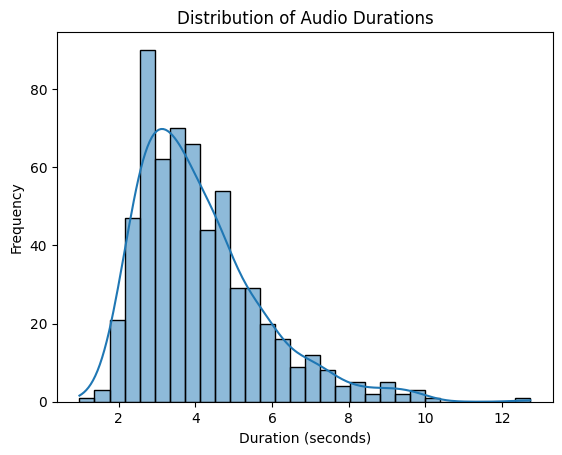

In [835]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

### Duration of the audio files by emotion
Table :

In [836]:
# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()
emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,122.0,4.591546,2.049071,2.035828,3.174796,4.078628,4.986196,12.734853


Histograms :

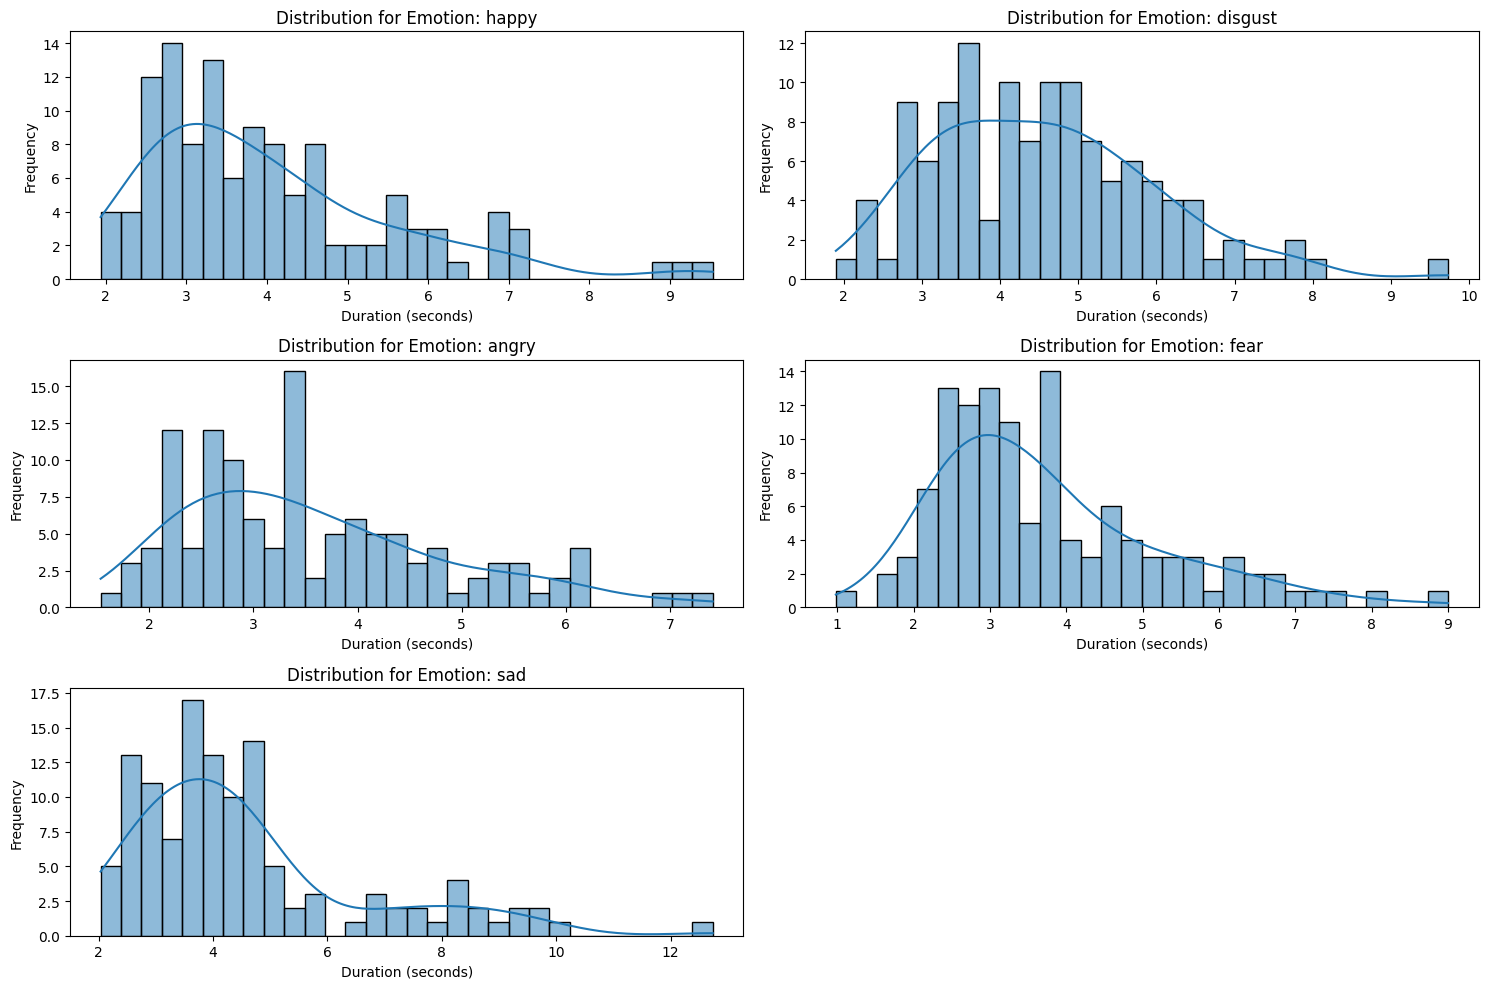

In [837]:
# Supposons que 'emotion' est une colonne dans df_metadata
categories = df_metadata['emotion'].unique()  # Obtenir les catégories uniques

# Créer une figure avec 5 plots (1 pour chaque catégorie)
plt.figure(figsize=(15, 10))  # Ajuster la taille globale

for i, category in enumerate(categories, 1):  # Boucle sur les catégories
    plt.subplot(3, 2, i)  # Disposer les plots en 3x2 (modifiez si nécessaire)
    sns.histplot(
        df_metadata[df_metadata['emotion'] == category]['duration_sec'],
        bins=30,
        kde=True
    )
    plt.title(f"Distribution for Emotion: {category}")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")

plt.tight_layout()  # Ajuster automatiquement l'espacement
plt.show()

We cannot observe important variation of duration according to emotion.

---

## 1.B - **Data processing**

### Noise Reduction

We reduce noise using the `noisereduce` package.

In [838]:
import librosa.display
import noisereduce as nr


# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=None):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    noise_profile = y[:int(sr * 1)]

# Reduce noise
    y = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

### Mel spectogram
Mel spectrograms transform audio files into numeric representations using the Discrete Fourier Transform.

In [839]:
import numpy as np

# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Function to visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

We create a column to store the mel spectrogram, and plot an example of a mel spectrogram for the first file.

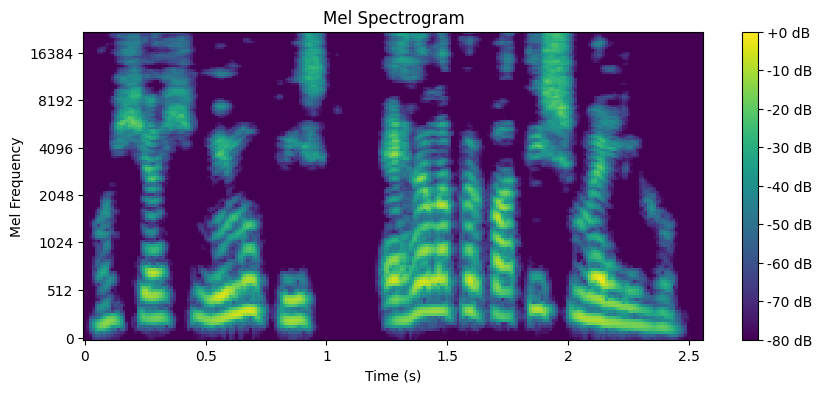

In [840]:
# We add a new column to store the Mel Spectrogram data
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
                
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Visualize the spectrogram for the first file
        if index == 0:
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

We export all the Mel spectrograms plots and save them in the folder *processed_spectrogram* (avalaible on [GitHub](https://github.com/SigurdST/emotion_recognition)).

In [841]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })

output_dir = "plot_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()

### Mean decibel values in the spectrograms for every emotion

In [842]:
mean_sum_db = 0
for spec in df_metadata['mel_spectrogram']:
    mean_sum_db += np.sum(spec)/spec.shape[1]
mean_sum_db /= len(df_metadata['mel_spectrogram'])
print(f"Mean sum of dB values: {mean_sum_db}")

# Créer une structure pour stocker les résultats
mean_sum_db_by_emotion = {}

# Calculer la mean sum pour chaque émotion
for emotion in df_metadata['emotion'].unique():
    # Filtrer les spectrogrammes pour l'émotion actuelle
    specs = df_metadata[df_metadata['emotion'] == emotion]['mel_spectrogram']
    
    # Initialiser la somme totale pour cette émotion
    total_sum_db = 0
    
    # Parcourir les spectrogrammes de l'émotion
    for spec in specs:
        total_sum_db += np.sum(spec) / spec.shape[1]
    
    # Calculer la moyenne pour cette émotion
    mean_sum_db_by_emotion[emotion] = total_sum_db / len(specs)

# Afficher les résultats
for emotion, mean_sum in mean_sum_db_by_emotion.items():
    print(f"Emotion: {emotion}, mean sum of dB values: {mean_sum}")

Mean sum of dB values: -8450.106890589786
Emotion: happy, mean sum of dB values: -8413.536775910055
Emotion: disgust, mean sum of dB values: -8554.73667156356
Emotion: angry, mean sum of dB values: -8281.237260056003
Emotion: fear, mean sum of dB values: -8387.866761152081
Emotion: sad, mean sum of dB values: -8609.853211861911


We do not observe a significant difference in the means.

---

---

# 2 - ***Convolutional Neural Network***
### Data preparation to modelisation
We prepare the data for the neural network by labeling the target variable and creating training and test sets.

In [843]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode emotions
label_encoder = LabelEncoder()
df_metadata['emotion_encoded'] = label_encoder.fit_transform(df_metadata['emotion'])

# Split the data
train_df, test_df = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata['emotion_encoded'], random_state=42)

# Display the mapping between labels and emotions
emotion_label_mapping = {label: emotion for label, emotion in enumerate(label_encoder.classes_)}
print("Mapping between labels and emotions:", emotion_label_mapping)

Mapping between labels and emotions: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad'}


We create custom `PyTorch` Dataset class that wraps a DataFrame containing Mel spectrograms and their corresponding labels.

In [844]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Class to convert the DataFrame to a PyTorch Dataset with tensors
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']

        # Normalize the spectrogram
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Convert the NumPy array to PyTorch tensors
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor


# Create the datasets
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)

### Functions to train and evaluate our CNNs

In [948]:
# Function to train the model
def train_model(model, train_loader, test_loader, learning_rate, num_epochs, device=device):
    # Move the model to the specified device
    model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    # Variable to store the best model
    best_model_state = None
    best_test_loss = float('inf')  # Initialize with a very large value
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        
        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation
            for inputs, targets in test_loader:
                # Move inputs and targets to the specified device
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute test loss
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                # Compute predictions
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Compute average test loss
        average_test_loss = test_loss / len(test_loader)
        test_losses.append(average_test_loss)

        # Save the model if this is the best test loss
        if average_test_loss < best_test_loss:
            best_test_loss = average_test_loss
            best_model_state = model.state_dict()  # Save model parameters
            best_epoch = epoch + 1
            torch.save(best_model_state, "best_model.pth")  # Save best model to disk

        # Display metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            # Calculate and display accuracy
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}")
            print(f"Test Loss after Epoch {epoch+1}: {average_test_loss:.4f}")
            print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")
            print("-" * 50)

    # Load the best model's parameters before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_model_state, train_losses, test_losses, {"Best epoch": best_epoch, "Best test loss": best_test_loss}


# Function to plot the loss curve
def plot_loss_curves(train_losses, test_losses):

    if train_losses and test_losses:
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()



# Function to evaluate the model
def evaluate_model(model, test_loader, device=device):

    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy after moving them to the CPU
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)

    # Print metrics
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return {"accuracy": accuracy}

The fist issue is that all the spectrograms don't have the same size. To adapt to this, we try two methods :
- CNNs with batch size of 1
- CNNs with resized data

We will then compare which method is better.

The second issue is that we have a small dataset (604 audio files). To adapt to this we will try to increase the size of our dataset.

---

## 2.A - **CNNs with batch of size 1**

### 2.A.1 - *3 Layers*

In [944]:
# Create the data loaders with a batch size of 1
train_loader_bs1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

# CNN model with 3 layers
class EmotionCNN3layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Number of classes
num_classes = len(label_encoder.classes_)


### Train with learning rate = 0.01

In [ ]:
model_bs1_3lay1 = EmotionCNN3layBS1(num_classes=num_classes)
best_model_bs1_3lay1, train_losses, test_losses, best_info = train_model(model_bs1_3lay1, train_loader_bs1, test_loader_bs1, 0.01, 5)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Loss:", best_info["Best test loss"])

Epoch 5/5, Training Loss: 1.6170
Test Loss after Epoch 5: 1.6100
Test Accuracy after Epoch 5: 19.83%
--------------------------------------------------
Best Epoch: 4
Best Test Loss: 1.6096850111464824


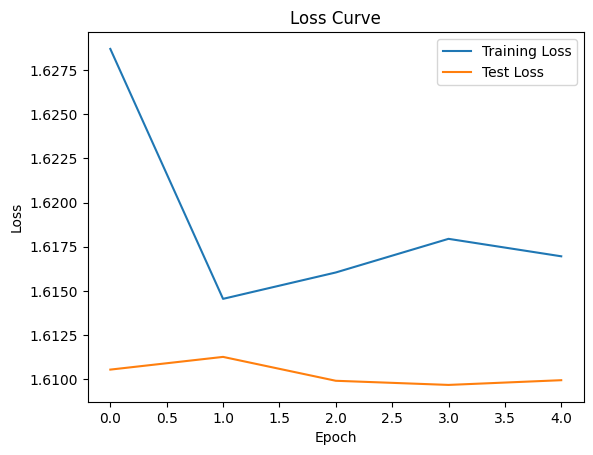

In [951]:
plot_loss_curves(train_losses, test_losses)

In [954]:
# Recreate the model architecture
best_model = EmotionCNN3layBS1(num_classes=num_classes)

# Load the saved parameters into the model
best_model.load_state_dict(torch.load("best_model.pth"))

# Evaluate the model
evaluate_model(best_model, test_loader_bs1, device=device)

Test Accuracy: 20.66%


### Train with learning rate = 0.001

In [937]:
model_bs1_3lay2 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses, test_losses = train_model(model_bs1_3lay2, train_loader_bs1, test_loader_bs1, 0.001, 300)

New best model found at Epoch 1 with Test Loss: 1.6110
New best model found at Epoch 2 with Test Loss: 1.6095
New best model found at Epoch 4 with Test Loss: 1.6091
New best model found at Epoch 5 with Test Loss: 1.6077
Epoch 5/300, Training Loss: 1.6107
Test Loss after Epoch 5: 1.6077
Test Accuracy after Epoch 5: 19.83%
--------------------------------------------------
New best model found at Epoch 6 with Test Loss: 1.6009
New best model found at Epoch 7 with Test Loss: 1.5925
New best model found at Epoch 8 with Test Loss: 1.5815
New best model found at Epoch 9 with Test Loss: 1.5766
New best model found at Epoch 10 with Test Loss: 1.5646
Epoch 10/300, Training Loss: 1.5804
Test Loss after Epoch 10: 1.5646
Test Accuracy after Epoch 10: 27.27%
--------------------------------------------------
New best model found at Epoch 11 with Test Loss: 1.5458
New best model found at Epoch 12 with Test Loss: 1.5265
New best model found at Epoch 13 with Test Loss: 1.4987
New best model found at E

KeyboardInterrupt: 

Test Accuracy: 63.64%
Precision: 67.88%
Recall: 63.64%


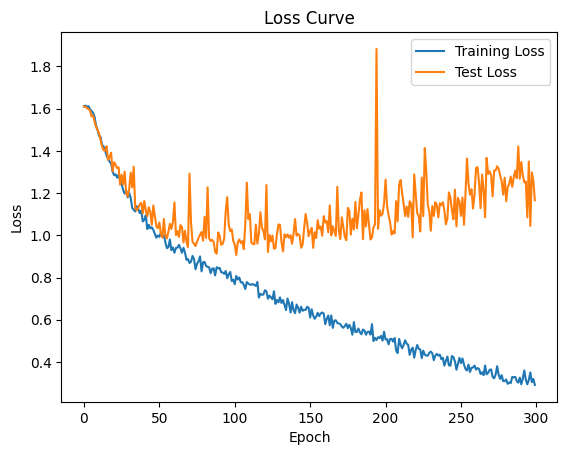

In [ ]:
eval_and_plot(model_bs1_3lay2, test_loader_bs1, train_losses, test_losses)

### Train with learning rate = 0.0001

In [852]:
model_bs1_3lay3 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay3, train_loader_bs1, 0.0001, 100)

Epoch 1/100, Loss: 1.6134
Epoch 2/100, Loss: 1.6082
Epoch 3/100, Loss: 1.6062
Epoch 4/100, Loss: 1.6073
Epoch 5/100, Loss: 1.6083
Epoch 6/100, Loss: 1.6027
Epoch 7/100, Loss: 1.5985
Epoch 8/100, Loss: 1.5951
Epoch 9/100, Loss: 1.5878
Epoch 10/100, Loss: 1.5795
Epoch 11/100, Loss: 1.5786
Epoch 12/100, Loss: 1.5665
Epoch 13/100, Loss: 1.5658
Epoch 14/100, Loss: 1.5634
Epoch 15/100, Loss: 1.5648
Epoch 16/100, Loss: 1.5550
Epoch 17/100, Loss: 1.5595
Epoch 18/100, Loss: 1.5488
Epoch 19/100, Loss: 1.5476
Epoch 20/100, Loss: 1.5533
Epoch 21/100, Loss: 1.5476
Epoch 22/100, Loss: 1.5537
Epoch 23/100, Loss: 1.5472
Epoch 24/100, Loss: 1.5417
Epoch 25/100, Loss: 1.5348
Epoch 26/100, Loss: 1.5318
Epoch 27/100, Loss: 1.5424
Epoch 28/100, Loss: 1.5383
Epoch 29/100, Loss: 1.5383
Epoch 30/100, Loss: 1.5356
Epoch 31/100, Loss: 1.5494
Epoch 32/100, Loss: 1.5315
Epoch 33/100, Loss: 1.5227
Epoch 34/100, Loss: 1.5316
Epoch 35/100, Loss: 1.5316
Epoch 36/100, Loss: 1.5175
Epoch 37/100, Loss: 1.5178
Epoch 38/1

Test Accuracy: 64.46%
Precision: 65.93%
Recall: 64.46%


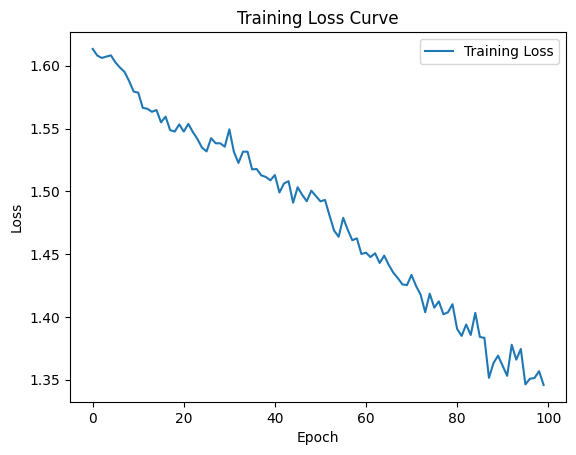

In [ ]:
eval_and_plot(model_bs1_3lay3, test_loader_bs1, train_losses)

### 2.A.2 - *4 Layers*

In [854]:
# CNN model with 4 layers
class EmotionCNN4layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [855]:
model_bs1_4lay1 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay1, train_loader_bs1, 0.001, 50)

Epoch 1/50, Loss: 1.6155
Epoch 2/50, Loss: 1.5830
Epoch 3/50, Loss: 1.4996
Epoch 4/50, Loss: 1.4174
Epoch 5/50, Loss: 1.3260
Epoch 6/50, Loss: 1.2600
Epoch 7/50, Loss: 1.2321
Epoch 8/50, Loss: 1.1902
Epoch 9/50, Loss: 1.1872
Epoch 10/50, Loss: 1.1316
Epoch 11/50, Loss: 1.1058
Epoch 12/50, Loss: 1.0853
Epoch 13/50, Loss: 1.0785
Epoch 14/50, Loss: 1.0382
Epoch 15/50, Loss: 0.9787
Epoch 16/50, Loss: 0.9559
Epoch 17/50, Loss: 0.9237
Epoch 18/50, Loss: 0.9002
Epoch 19/50, Loss: 0.9149
Epoch 20/50, Loss: 0.8633
Epoch 21/50, Loss: 0.7983
Epoch 22/50, Loss: 0.7541
Epoch 23/50, Loss: 0.7377
Epoch 24/50, Loss: 0.6575
Epoch 25/50, Loss: 0.6442
Epoch 26/50, Loss: 0.6372
Epoch 27/50, Loss: 0.5827
Epoch 28/50, Loss: 0.4942
Epoch 29/50, Loss: 0.4752
Epoch 30/50, Loss: 0.4216
Epoch 31/50, Loss: 0.3887
Epoch 32/50, Loss: 0.3714
Epoch 33/50, Loss: 0.3679
Epoch 34/50, Loss: 0.3582
Epoch 35/50, Loss: 0.2683
Epoch 36/50, Loss: 0.1974
Epoch 37/50, Loss: 0.2372
Epoch 38/50, Loss: 0.1851
Epoch 39/50, Loss: 0.

Test Accuracy: 64.46%
Precision: 70.38%
Recall: 64.46%


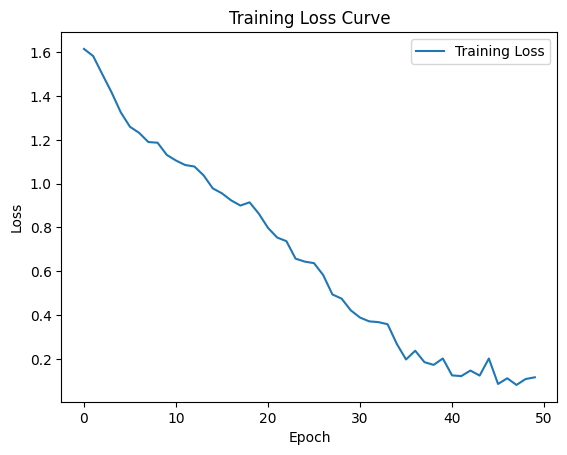

In [856]:
# Evaluate the model
eval_and_plot(model_bs1_4lay1, test_loader_bs1, train_losses)

### Train with learning rate = 0.0001

In [857]:
model_bs1_4lay2 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay2, train_loader_bs1, 0.0001, 150)

Epoch 1/150, Loss: 1.6134
Epoch 2/150, Loss: 1.6112
Epoch 3/150, Loss: 1.6072
Epoch 4/150, Loss: 1.6031
Epoch 5/150, Loss: 1.5964
Epoch 6/150, Loss: 1.5835
Epoch 7/150, Loss: 1.5622
Epoch 8/150, Loss: 1.5400
Epoch 9/150, Loss: 1.5157
Epoch 10/150, Loss: 1.4874
Epoch 11/150, Loss: 1.4783
Epoch 12/150, Loss: 1.4411
Epoch 13/150, Loss: 1.4276
Epoch 14/150, Loss: 1.4022
Epoch 15/150, Loss: 1.3945
Epoch 16/150, Loss: 1.3736
Epoch 17/150, Loss: 1.3582
Epoch 18/150, Loss: 1.3330
Epoch 19/150, Loss: 1.3151
Epoch 20/150, Loss: 1.3055
Epoch 21/150, Loss: 1.2997
Epoch 22/150, Loss: 1.2874
Epoch 23/150, Loss: 1.2587
Epoch 24/150, Loss: 1.2436
Epoch 25/150, Loss: 1.2520
Epoch 26/150, Loss: 1.2421
Epoch 27/150, Loss: 1.1802
Epoch 28/150, Loss: 1.2270
Epoch 29/150, Loss: 1.2112
Epoch 30/150, Loss: 1.1557
Epoch 31/150, Loss: 1.1878
Epoch 32/150, Loss: 1.1582
Epoch 33/150, Loss: 1.1463
Epoch 34/150, Loss: 1.1473
Epoch 35/150, Loss: 1.1506
Epoch 36/150, Loss: 1.1379
Epoch 37/150, Loss: 1.1348
Epoch 38/1

Test Accuracy: 62.81%
Precision: 63.94%
Recall: 62.81%


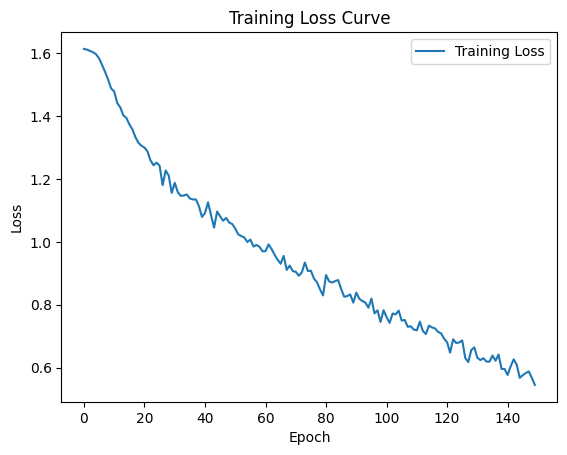

In [858]:
eval_and_plot(model_bs1_4lay2, test_loader_bs1, train_losses)

---

## 2.B - **CNNs with resized spectrograms**

### 2.B.1 - *Resize the Mel spectrogram to size $128\times256$ using padding and interpolation method*

In [859]:
# Class to create a resized Mel Spectrogram dataset with tensors
class MelSpectrogramDatasetResized(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()
        mel_spectrogram = self._resize_mel_spectrogram(mel_spectrogram)
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor

    def _resize_mel_spectrogram(self, mel_spectrogram):

        target_size = 256

        # If spectrogram width is smaller than target, pad with zeros
        if mel_spectrogram.shape[1] < target_size:
            padding = target_size - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

        # If spectrogram width is larger than target, interpolate
        elif mel_spectrogram.shape[1] > target_size:
            mel_spectrogram = librosa.resample(
                mel_spectrogram,
                orig_sr=mel_spectrogram.shape[1],
                target_sr=target_size)

        return mel_spectrogram
    
# Create the datasets
train_dataset_resized = MelSpectrogramDatasetResized(train_df)
test_dataset_resized = MelSpectrogramDatasetResized(test_df)

### 2.B.2 - *3 layers CNN*

In [860]:
# Create the data loaders with a batch size of 8
train_loader_res = DataLoader(train_dataset_resized, batch_size=8, shuffle=True)
test_loader_res = DataLoader(test_dataset_resized, batch_size=8, shuffle=False)

class EmotionCNN3lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(64 * 16 * 32, num_classes)
        self.dropout = nn.Dropout(0.75)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with lr = 0.001

In [861]:
model_bs1_3lay_res2 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay_res2, train_loader_res, 0.001, 25)

Epoch 1/25, Loss: 5.3525
Epoch 2/25, Loss: 2.8727
Epoch 3/25, Loss: 2.4515
Epoch 4/25, Loss: 2.2326
Epoch 5/25, Loss: 2.1054
Epoch 6/25, Loss: 1.3071
Epoch 7/25, Loss: 1.3788
Epoch 8/25, Loss: 1.1573
Epoch 9/25, Loss: 1.0793
Epoch 10/25, Loss: 0.7016
Epoch 11/25, Loss: 1.0330
Epoch 12/25, Loss: 0.7092
Epoch 13/25, Loss: 0.6674
Epoch 14/25, Loss: 0.5338
Epoch 15/25, Loss: 0.5285
Epoch 16/25, Loss: 0.4073
Epoch 17/25, Loss: 0.3674
Epoch 18/25, Loss: 0.5884
Epoch 19/25, Loss: 0.5048
Epoch 20/25, Loss: 0.4692
Epoch 21/25, Loss: 0.4921
Epoch 22/25, Loss: 0.2412
Epoch 23/25, Loss: 0.4910
Epoch 24/25, Loss: 0.3948
Epoch 25/25, Loss: 0.2256


Test Accuracy: 44.63%
Precision: 45.54%
Recall: 44.63%


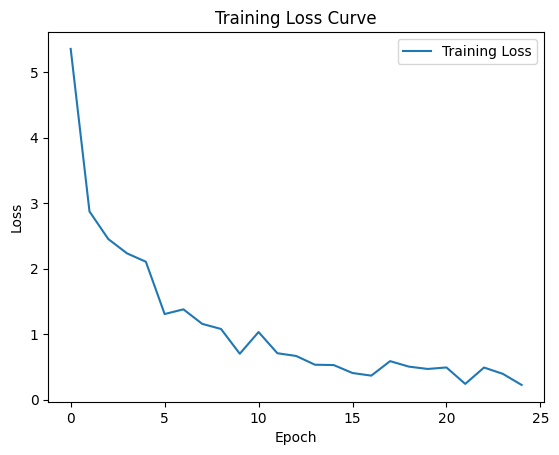

In [862]:
eval_and_plot(model_bs1_3lay_res2, test_loader_res, train_losses)

### Train with lr = 0.0001

In [863]:
model_bs1_3lay_res1 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay_res1, train_loader_res, 0.0001, 15)

Epoch 1/15, Loss: 2.0911
Epoch 2/15, Loss: 1.4762
Epoch 3/15, Loss: 1.2397
Epoch 4/15, Loss: 0.9596
Epoch 5/15, Loss: 0.9650
Epoch 6/15, Loss: 0.6740
Epoch 7/15, Loss: 0.5448
Epoch 8/15, Loss: 0.5028
Epoch 9/15, Loss: 0.4935
Epoch 10/15, Loss: 0.4152
Epoch 11/15, Loss: 0.3668
Epoch 12/15, Loss: 0.3850
Epoch 13/15, Loss: 0.2926
Epoch 14/15, Loss: 0.2529
Epoch 15/15, Loss: 0.1926


Test Accuracy: 49.59%
Precision: 50.85%
Recall: 49.59%


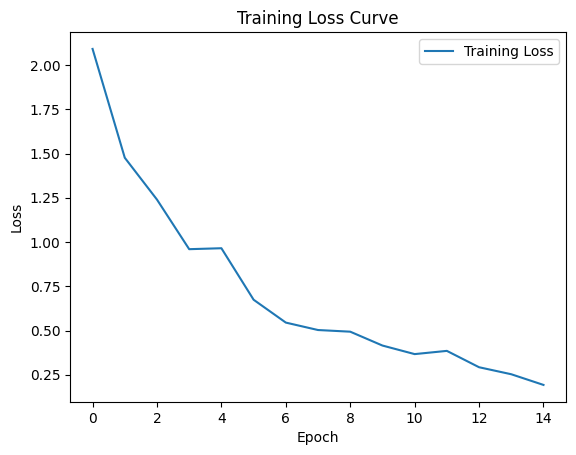

In [864]:
eval_and_plot(model_bs1_3lay_res1, test_loader_res, train_losses)

### 2.B.3 - *4 layers CNN*

In [865]:
class EmotionCNN4lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)  # Adjust based on final output shape of conv layers

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x



### Train with learning rate = 0.001

In [866]:
model_bs1_4lay_res2 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res2, train_loader_res, 0.001, 10)

Epoch 1/10, Loss: 4.1459
Epoch 2/10, Loss: 2.0125
Epoch 3/10, Loss: 1.9779
Epoch 4/10, Loss: 1.3836
Epoch 5/10, Loss: 1.1061
Epoch 6/10, Loss: 0.7649
Epoch 7/10, Loss: 0.9906
Epoch 8/10, Loss: 0.5135
Epoch 9/10, Loss: 0.4060
Epoch 10/10, Loss: 0.3199


Test Accuracy: 55.37%
Precision: 52.10%
Recall: 55.37%


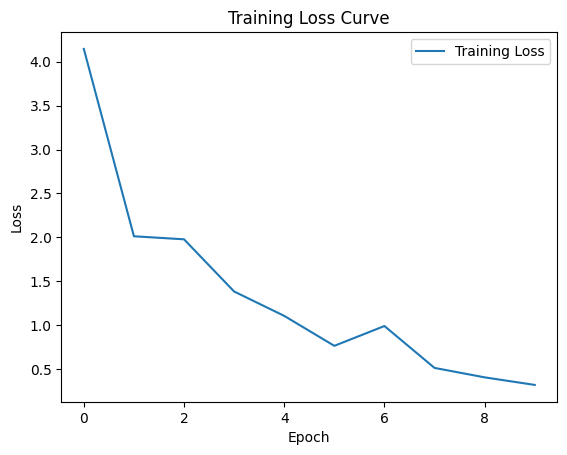

In [867]:
eval_and_plot(model_bs1_4lay_res2, test_loader_res, train_losses)

### Train with learning rate = 0.0001

In [868]:
model_bs1_4lay_res1 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res1, train_loader_res, 0.0001, 10)

Epoch 1/10, Loss: 1.8370
Epoch 2/10, Loss: 1.1253
Epoch 3/10, Loss: 0.9092
Epoch 4/10, Loss: 0.6138
Epoch 5/10, Loss: 0.4566
Epoch 6/10, Loss: 0.3472
Epoch 7/10, Loss: 0.2498
Epoch 8/10, Loss: 0.1943
Epoch 9/10, Loss: 0.1509
Epoch 10/10, Loss: 0.1167


Test Accuracy: 50.41%
Precision: 49.14%
Recall: 50.41%


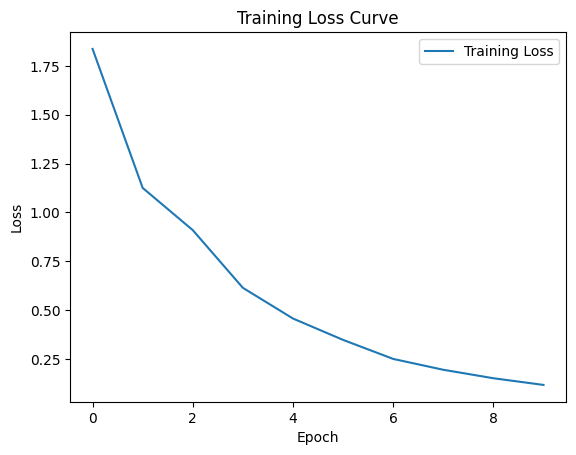

In [869]:
eval_and_plot(model_bs1_4lay_res1, test_loader_res, train_losses)

---

## 2.C - **CNNs on artificial data**

### 2.C.1 - *Data augmentation techniques*

We create 4 fonctions that can modify our Mel spectrograms to create new data.

In [870]:
import random

# Function to add noise to the spectrogram
def add_noise(spectrogram, noise_level=0.01):
    noise = np.random.normal(0, noise_level, spectrogram.shape)
    return spectrogram + noise

# Function to shift the pitch of the spectrogram
def pitch_shift(spectrogram, sr, n_steps):
    return librosa.effects.pitch_shift(spectrogram, sr=sr, n_steps=n_steps)

# Function to apply a frequency mask
def freq_mask(spectrogram, freq_mask_param):
    spec = spectrogram.copy()
    f = random.randint(0, freq_mask_param)
    f0 = random.randint(0, spec.shape[0] - f)
    spec[f0:f0 + f, :] = 0
    return spec

# Function to apply a time mask
def time_mask(spectrogram, time_mask_param):
    spec = spectrogram.copy()
    t = random.randint(0, time_mask_param)
    t0 = random.randint(0, spec.shape[1] - t)
    spec[:, t0:t0 + t] = 0
    return spec

# We apply the functions on the train set
augmented_data = []

for spec in train_df['mel_spectrogram']:

    for i in range(10):

        augmented = spec.copy()
        
        # Apply random transformations
        if random.random() < 0.6:
            augmented = add_noise(augmented)
        if random.random() < 0.6:
            n_steps = random.uniform(-4, 4)
            augmented = librosa.db_to_power(augmented)
            augmented = pitch_shift(augmented, sr, n_steps)
            augmented = librosa.power_to_db(augmented)
        if random.random() < 0.6:
            freq_mask_param = random.randint(10, 30)
            augmented = freq_mask(augmented, freq_mask_param)
        if random.random() < 0.6:
            time_mask_param = random.randint(10, 50)
            augmented = time_mask(augmented, time_mask_param)

        augmented_data.append(augmented)

We create a dataset with the augmented_data and the correponding label and convert them to tensor.

In [871]:
augmented_emotion = train_df['emotion'].values.repeat(10)

train_df_augmented = pd.DataFrame({
    'mel_spectrogram': augmented_data,
    'emotion': augmented_emotion
})

train_df_augmented['emotion_encoded'] = label_encoder.transform(train_df_augmented['emotion'])
train_dataset_augmented = MelSpectrogramDataset(train_df_augmented)
train_loader_augmented_bs1 = DataLoader(train_dataset_augmented, batch_size=1, shuffle=True)


### 2.C.2 - *CNN with batch size of 1*

We only do 4 layers because cit converges faster and computation are slow.

In [872]:
model_bs1_4lay_aug = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_aug, train_loader_augmented_bs1, 0.001, 50)

Epoch 1/50, Loss: 1.6035
Epoch 2/50, Loss: 1.4957
Epoch 3/50, Loss: 1.3999
Epoch 4/50, Loss: 1.3382
Epoch 5/50, Loss: 1.2999
Epoch 6/50, Loss: 1.2677
Epoch 7/50, Loss: 1.2390
Epoch 8/50, Loss: 1.2032
Epoch 9/50, Loss: 1.1690
Epoch 10/50, Loss: 1.1461
Epoch 11/50, Loss: 1.1044
Epoch 12/50, Loss: 1.0751
Epoch 13/50, Loss: 1.0347
Epoch 14/50, Loss: 0.9968
Epoch 15/50, Loss: 0.9770
Epoch 16/50, Loss: 0.9362
Epoch 17/50, Loss: 0.9080
Epoch 18/50, Loss: 0.8821
Epoch 19/50, Loss: 0.8335
Epoch 20/50, Loss: 0.7934
Epoch 21/50, Loss: 0.7762
Epoch 22/50, Loss: 0.7547
Epoch 23/50, Loss: 0.7064
Epoch 24/50, Loss: 0.6863
Epoch 25/50, Loss: 0.6603
Epoch 26/50, Loss: 0.6433
Epoch 27/50, Loss: 0.6192
Epoch 28/50, Loss: 0.5768
Epoch 29/50, Loss: 0.5528
Epoch 30/50, Loss: 0.5351
Epoch 31/50, Loss: 0.5152
Epoch 32/50, Loss: 0.4621
Epoch 33/50, Loss: 0.4521
Epoch 34/50, Loss: 0.4561
Epoch 35/50, Loss: 0.4321
Epoch 36/50, Loss: 0.4107
Epoch 37/50, Loss: 0.3935
Epoch 38/50, Loss: 0.3875
Epoch 39/50, Loss: 0.

Test Accuracy: 55.37%
Precision: 56.78%
Recall: 55.37%


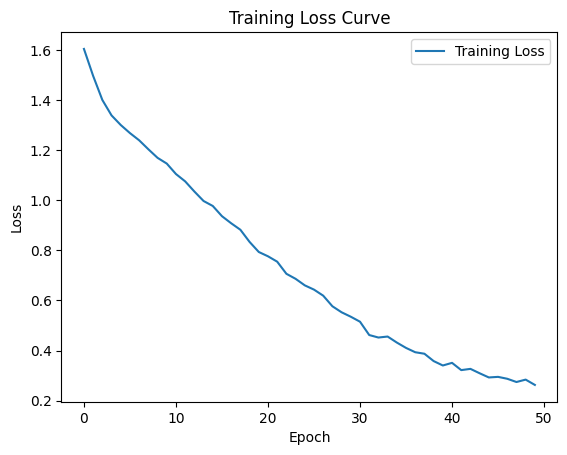

In [873]:
eval_and_plot(model_bs1_4lay_aug, test_loader_bs1, train_losses)

### 2.C.3 - *CNN with resized data*

In [874]:
train_dataset_augmented_resized = MelSpectrogramDatasetResized(train_df_augmented)
train_loader_augmented_res = DataLoader(train_dataset_augmented_resized, batch_size=16, shuffle=True)

class EmotionCNN4lay_res_aug(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res_aug, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [875]:
model_bs1_4lay_res_aug = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res_aug, train_loader_augmented_res, 0.001, 10)

Epoch 1/10, Loss: 2.0827
Epoch 2/10, Loss: 1.3593
Epoch 3/10, Loss: 0.9393
Epoch 4/10, Loss: 0.6711
Epoch 5/10, Loss: 0.4787
Epoch 6/10, Loss: 0.3418
Epoch 7/10, Loss: 0.2460
Epoch 8/10, Loss: 0.1652
Epoch 9/10, Loss: 0.1186
Epoch 10/10, Loss: 0.1081


Test Accuracy: 52.07%
Precision: 55.46%
Recall: 52.07%


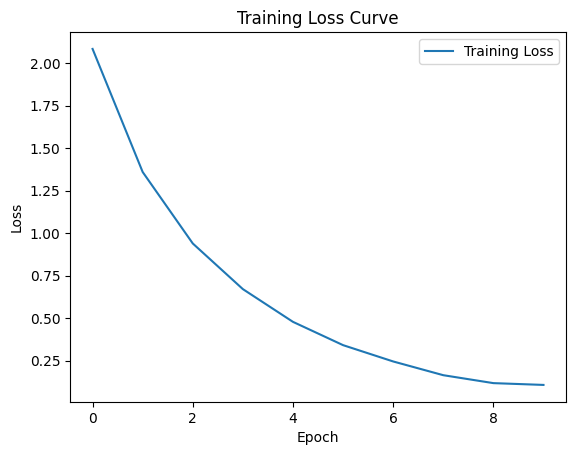

In [876]:
eval_and_plot(model_bs1_4lay_res_aug, test_loader_res, train_losses)

### Train with learning rate = 0.0001

In [877]:
model_bs1_4lay_res_aug2 = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res_aug2, train_loader_augmented_res, 0.0001, 10)

Epoch 1/10, Loss: 1.4563
Epoch 2/10, Loss: 0.9503
Epoch 3/10, Loss: 0.6441
Epoch 4/10, Loss: 0.4617
Epoch 5/10, Loss: 0.3329
Epoch 6/10, Loss: 0.2337
Epoch 7/10, Loss: 0.1986
Epoch 8/10, Loss: 0.1384
Epoch 9/10, Loss: 0.1064
Epoch 10/10, Loss: 0.0838


Test Accuracy: 56.20%
Precision: 58.13%
Recall: 56.20%


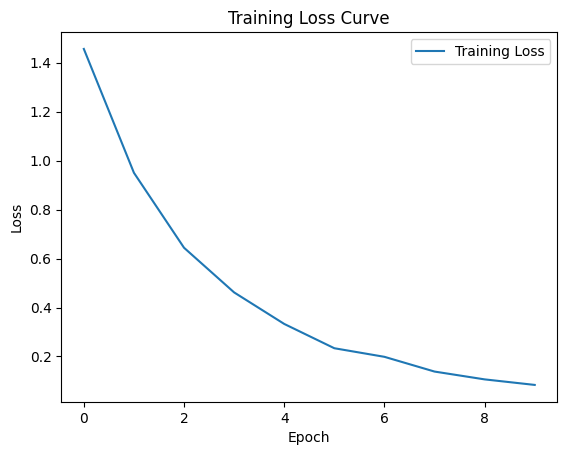

In [878]:
eval_and_plot(model_bs1_4lay_res_aug2, test_loader_res, train_losses)

---
---